In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 0.001

In [3]:
(train_data, val_data, test_data), metadata = tfds.load('mnist',
                                                        split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                        with_info = True)

print(metadata.features)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


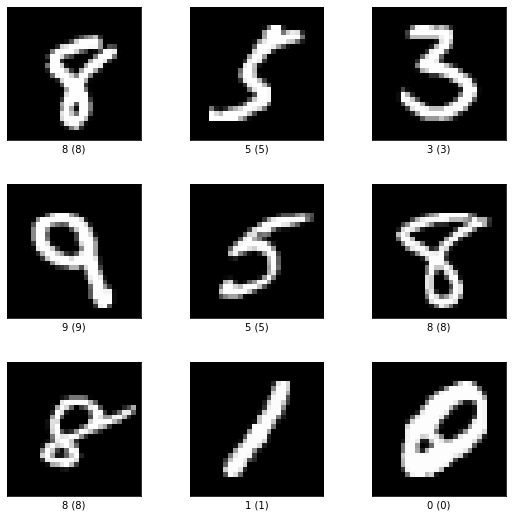

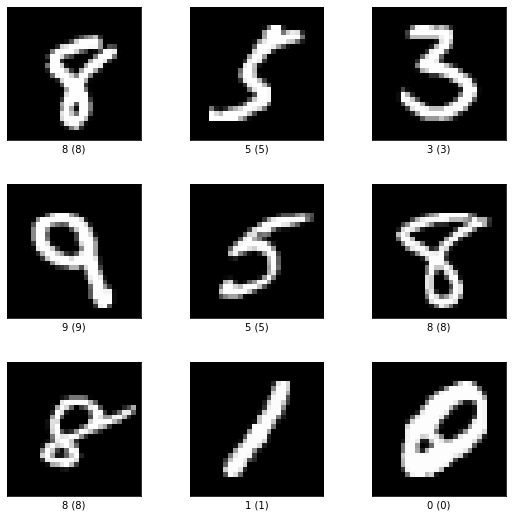

In [4]:
tfds.visualization.show_examples(val_data, metadata)

In [5]:
def preprocess(dataset):
  image = tf.cast(dataset['image'], dtype = tf.float32) / 255,
  label = tf.cast(dataset['label'], dtype = tf.int64)
  return image, label

train_data = train_data.map(preprocess).shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_data = val_data.map(preprocess).batch(BATCH_SIZE)
test_data = test_data.map(preprocess).batch(BATCH_SIZE)

In [6]:
def simple_convolution_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(28, 28, 1,))
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.models.Model(input_, output_, name='Classifier')


num_classes = metadata.features['label'].num_classes
model = simple_convolution_model(num_classes)
model.summary()

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LEARNING_RATE,
                                                             decay_steps=100000,
                                                             decay_rate=0.96)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

history = model.fit(train_data, epochs=EPOCHS, validation_data = val_data)

Epoch 1/20
94/94 [==============================] - 104s 1s/step - loss: 0.7499 - accuracy: 0.7780 - val_loss: 0.1941 - val_accuracy: 0.9383
Epoch 2/20
94/94 [==============================] - 95s 1s/step - loss: 0.1487 - accuracy: 0.9536 - val_loss: 0.1174 - val_accuracy: 0.9628
Epoch 3/20
94/94 [==============================] - 97s 1s/step - loss: 0.1016 - accuracy: 0.9685 - val_loss: 0.0875 - val_accuracy: 0.9725
Epoch 4/20
94/94 [==============================] - 95s 1s/step - loss: 0.0813 - accuracy: 0.9744 - val_loss: 0.0903 - val_accuracy: 0.9713
Epoch 5/20
94/94 [==============================] - 97s 1s/step - loss: 0.0683 - accuracy: 0.9781 - val_loss: 0.0675 - val_accuracy: 0.9800
Epoch 6/20
94/94 [==============================] - 93s 988ms/step - loss: 0.0556 - accuracy: 0.9829 - val_loss: 0.0655 - val_accuracy: 0.9790
Epoch 7/20
94/94 [==============================] - 95s 1s/step - loss: 0.0504 - accuracy: 0.9844 - val_loss: 0.0594 - val_accuracy: 0.9810
Epoch 8/20
94/94

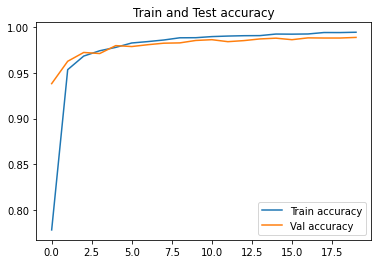

<Figure size 7200x7200 with 0 Axes>

In [8]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
plt.title('Train and Test accuracy')
plt.legend()
plt.figure(figsize=(100,100))
plt.show()

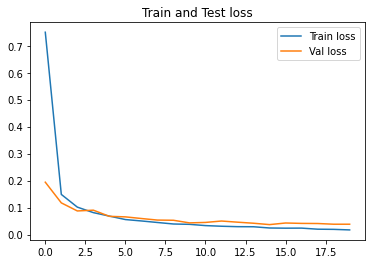

<Figure size 14400x14400 with 0 Axes>

In [9]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('Train and Test loss')
plt.legend()
plt.figure(figsize=(200,200))
plt.show()

In [10]:
metrics = model.evaluate(test_data, batch_size=BATCH_SIZE, verbose=1)
metric_names = ['Test loss', 'Test Accuracy']

for name, value in zip(metric_names, metrics):
    print(f'{name} : {value}')

12/12 [==============================] - 3s 227ms/step - loss: 0.0476 - accuracy: 0.9858
Test loss : 0.04756678268313408
Test Accuracy : 0.9858333468437195
